In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams.update({"figure.figsize": (8, 4), "axes.grid": True})

DATA_PATH = Path.cwd().parent / "data" / "sample_logs.parquet"
df = pd.read_parquet(DATA_PATH)


#### Purpose: confirm the file loads, column names are as expected, datatypes make sense (esp. ts as datetime), and there are no missing values that would break plots.

In [30]:

print(df.shape)
print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nNulls per column:\n", df.isna().sum())

df.head(3)

(10000, 7)
Columns: ['ts', 'level', 'status', 'path', 'latency_ms', 'user_id', 'msg']

Data types:
 ts            datetime64[ns]
level                 object
status                 int64
path                  object
latency_ms             int64
user_id                int64
msg                   object
dtype: object

Nulls per column:
 ts            0
level         0
status        0
path          0
latency_ms    0
user_id       0
msg           0
dtype: int64


,ts,level,status,path,latency_ms,user_id,msg
0,2025-09-04 16:39:25,INFO,200,/api/v1/orders,48,171,completed /api/v1/orders with 200
1,2025-09-04 16:39:26,INFO,404,/static/app.js,228,433,client error 404 on /static/app.js
2,2025-09-04 16:39:27,INFO,404,/,62,737,client error 404 on /


In [32]:
# Normalize text columns to string
text_cols = ["level", "path", "msg"]
df[text_cols] = df[text_cols].astype("string")
print("\nData types:\n", df.dtypes)




Data types:
 ts            datetime64[ns]
level         string[python]
status                 int64
path          string[python]
latency_ms             int64
user_id                int64
msg           string[python]
dtype: object


#### Latency histogram (+ quick stats)

In [40]:
lat = df["latency_ms"]
stats = lat.describe(percentiles=[0.9, 0.95, 0.99])
print(stats[["count","mean","std","min","90%","95%","99%","max"]])

count    10000.000000
mean       128.570700
std        155.130702
min         10.000000
90%        200.000000
95%        248.000000
99%        841.080000
max       4535.000000
Name: latency_ms, dtype: float64


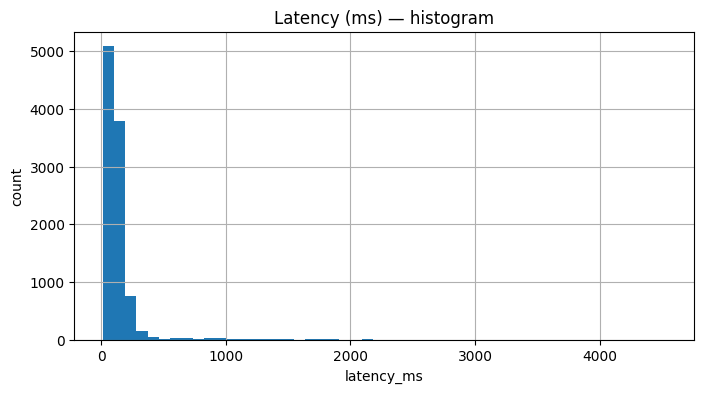

In [41]:
fig, ax = plt.subplots()
ax.hist(lat, bins=50)
ax.set_title("Latency (ms) — histogram")
ax.set_xlabel("latency_ms")
ax.set_ylabel("count")
plt.show()

### Latency tail via ECDF (percentiles view)
#### ECDF makes it easy to read percentiles directly and see how heavy the right tail is. We’ll mark p95 and p99.

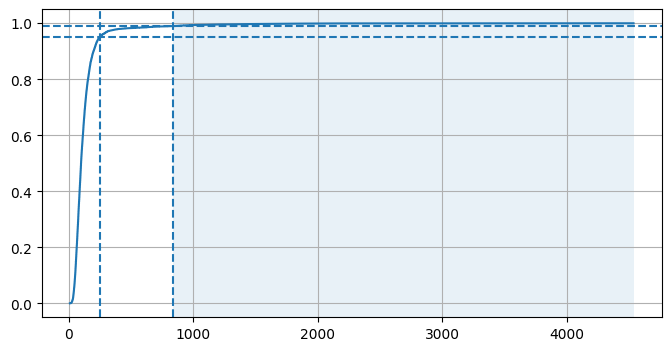

In [132]:
lat = df['latency_ms'].astype(float)
lat_sorted = np.sort(lat)
ecdf_y = np.arange(1, len(lat_sorted)+1)/len(lat_sorted)
fig, ax = plt.subplots()
p95=lat.quantile(0.95)
p99=lat.quantile(0.99)
ax.axhline(0.95, linestyle='--')
ax.axhline(0.99, linestyle='--')
ax.axvline(p95, linestyle='--')
ax.axvline(p99, linestyle='--')
ax.axvspan(p99, lat_sorted.max(), alpha=0.1)  # shaded = crossed p99
ax.plot(lat_sorted, ecdf_y)


### Status code distribution (+ 5xx rate)
#### To see the mix of responses and quantify failure rate.

<BarContainer object of 11 artists>

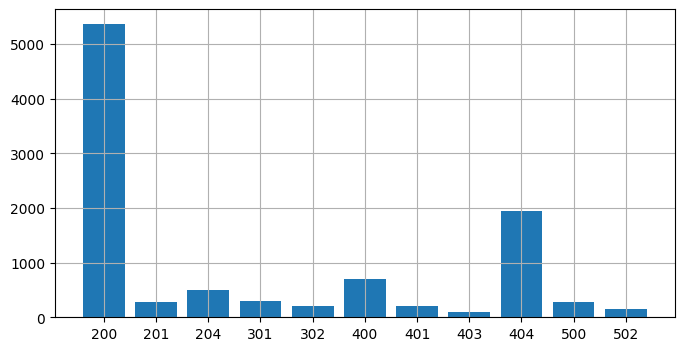

In [125]:
status_count = df["status"].value_counts().sort_index()
fig, ax = plt.subplots()
ax.bar(status_count.index.astype(str), status_count.values)

### Requests per hour (time series)

ts
2025-09-04 16:00:00    1235
2025-09-04 17:00:00    3600
2025-09-04 18:00:00    3600
2025-09-04 19:00:00    1565
Freq: h, dtype: int64


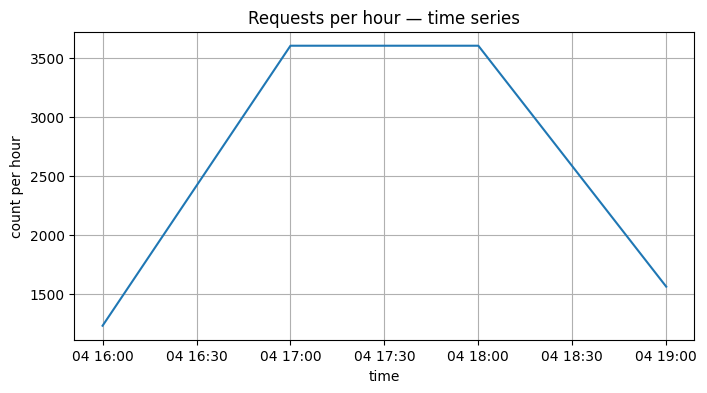

In [160]:
ts = df.set_index("ts").sort_index()
per_hour = ts.resample("h").size()

print(per_hour.head())
fig, ax = plt.subplots()
ax.plot(per_hour.index, per_hour.values)

ax.set_title("Requests per hour — time series")
ax.set_xlabel("time")
ax.set_ylabel("count per hour")

plt.show()
